## 1. Choose Model and Load it


In [1]:
from transformers import AutoModel, AutoTokenizer
import torch
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

# Load model and tokenizer
model_name = "gpt2"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set the pad_token to eos_token if not already set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


/Users/juliahagen/anaconda3/envs/llm_rsa_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Define Functions to Extract Activtions

In [2]:
# Dictionary to store activations
activations = {}

# Function to hook and capture the output from each layer
def get_activation(name):
    def hook(model, input, output):
        # Check if output has last_hidden_state attribute; if so, use it
        if hasattr(output, "last_hidden_state"):
            output = output.last_hidden_state
        elif isinstance(output, tuple):
            # If output is a tuple, take the first element (usually the main hidden states)
            output = output[0]
        activations[name] = output.detach()
    return hook

# Register hooks for each layer in the model
for name, layer in model.named_modules():
    layer.register_forward_hook(get_activation(name))



## 3. Prepare and Encode Text Data

In [3]:


# Prepare a batch of input texts
texts = [
    "The quick brown fox jumps over the lazy dog.",
    "Artificial intelligence is transforming the world.",
    "Data science combines domain expertise and programming skills.",
    "Machine learning enables computers to learn from data.",
    "Natural language processing helps computers understand human language."
]
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

# Dictionary to store activations
activations = {}

# Register hooks for each layer in the model
for name, layer in model.named_modules():
    layer.register_forward_hook(get_activation(name))

# Run a forward pass through the model
with torch.no_grad():
    model(**inputs)

# Check the activations dictionary
print("Captured layer activations:", activations.keys())


Captured layer activations: dict_keys(['wte', 'wpe', 'drop', 'h.0.ln_1', 'h.0.attn.c_attn', 'h.0.attn.c_proj', 'h.0.attn.resid_dropout', 'h.0.attn', 'h.0.ln_2', 'h.0.mlp.c_fc', 'h.0.mlp.act', 'h.0.mlp.c_proj', 'h.0.mlp.dropout', 'h.0.mlp', 'h.0', 'h.1.ln_1', 'h.1.attn.c_attn', 'h.1.attn.c_proj', 'h.1.attn.resid_dropout', 'h.1.attn', 'h.1.ln_2', 'h.1.mlp.c_fc', 'h.1.mlp.act', 'h.1.mlp.c_proj', 'h.1.mlp.dropout', 'h.1.mlp', 'h.1', 'h.2.ln_1', 'h.2.attn.c_attn', 'h.2.attn.c_proj', 'h.2.attn.resid_dropout', 'h.2.attn', 'h.2.ln_2', 'h.2.mlp.c_fc', 'h.2.mlp.act', 'h.2.mlp.c_proj', 'h.2.mlp.dropout', 'h.2.mlp', 'h.2', 'h.3.ln_1', 'h.3.attn.c_attn', 'h.3.attn.c_proj', 'h.3.attn.resid_dropout', 'h.3.attn', 'h.3.ln_2', 'h.3.mlp.c_fc', 'h.3.mlp.act', 'h.3.mlp.c_proj', 'h.3.mlp.dropout', 'h.3.mlp', 'h.3', 'h.4.ln_1', 'h.4.attn.c_attn', 'h.4.attn.c_proj', 'h.4.attn.resid_dropout', 'h.4.attn', 'h.4.ln_2', 'h.4.mlp.c_fc', 'h.4.mlp.act', 'h.4.mlp.c_proj', 'h.4.mlp.dropout', 'h.4.mlp', 'h.4', 'h.5.ln_1

## 4. Compute RSA on Layer Activations

In [4]:
from scipy.spatial.distance import pdist, squareform


# Compute and plot RDMs for each layer
def compute_rdm(activation_tensor):
    # Flatten the tensor if necessary
    act_flat = activation_tensor.view(activation_tensor.size(0), -1).cpu().numpy()
    # Compute pairwise distances (use cosine or correlation)
    distances = pdist(act_flat, metric="cosine")  # or "correlation"
    return squareform(distances)

# Compute RDMs for each layer’s activations
rdms = {layer: compute_rdm(act) for layer, act in activations.items()}
print(rdms)

{'wte': array([[0.        , 0.74522479, 0.73519289, 0.74444277, 0.73295908],
       [0.74522479, 0.        , 0.64356039, 0.6813103 , 0.64905914],
       [0.73519289, 0.64356039, 0.        , 0.56945296, 0.58511818],
       [0.74444277, 0.6813103 , 0.56945296, 0.        , 0.55821219],
       [0.73295908, 0.64905914, 0.58511818, 0.55821219, 0.        ]]), 'wpe': array([[0.]]), 'drop': array([[0.        , 0.21622222, 0.21238806, 0.21150754, 0.21421095],
       [0.21622222, 0.        , 0.19173756, 0.19983029, 0.19549988],
       [0.21238806, 0.19173756, 0.        , 0.16631181, 0.17552922],
       [0.21150754, 0.19983029, 0.16631181, 0.        , 0.16493072],
       [0.21421095, 0.19549988, 0.17552922, 0.16493072, 0.        ]]), 'h.0.ln_1': array([[0.        , 0.77014253, 0.76515034, 0.76310266, 0.76286586],
       [0.77014253, 0.        , 0.66314457, 0.68940506, 0.66598711],
       [0.76515034, 0.66314457, 0.        , 0.6009203 , 0.61618467],
       [0.76310266, 0.68940506, 0.6009203 , 0.   

## 5. Plot RDMs

### TSNE

In [ ]:
from sklearn.manifold import TSNE

# Initialize t-SNE model (using the same model for consistency across layers)
tsne = TSNE(n_components=2, metric="precomputed", random_state=42, perplexity = 2, init="random")

# Define a color palette for the layers
colors = sns.color_palette("hsv", len(activations))

# Plot all layers in a single figure
plt.figure(figsize=(10, 8))

for i, (layer, activation) in enumerate(activations.items()):
    # Compute the RDM and project to 2D with t-SNE
    rdm = compute_rdm(activation)
    points_2d = tsne.fit_transform(rdm)
    
    # Plot the points with a distinct color for each layer
    plt.scatter(points_2d[:, 0], points_2d[:, 1], s=100, color=colors[i], label=layer, edgecolor="k")
    
    # Optionally, label each point by sentence index
    for j, (x, y) in enumerate(points_2d):
        plt.text(x, y, str(j), fontsize=8, ha="right")

# Customize plot
plt.title("Overlayed t-SNE Representation of Sentence Similarities Across Layers")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
plt.tight_layout()
plt.show()

### MDS

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
import numpy as np

def plot_rdm_dotplot(rdm, layer_name):
    # Apply MDS to project dissimilarities into 2D space
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    points_2d = mds.fit_transform(rdm)
    
    # Plot the dot plot
    plt.figure(figsize=(8, 6))
    plt.scatter(points_2d[:, 0], points_2d[:, 1], s=100, c="blue", edgecolor="k")
    
    # Label points by index for reference
    for i, (x, y) in enumerate(points_2d):
        plt.text(x, y, str(i), fontsize=12, ha="right")
    
    plt.title(f"Dot Plot of Sentence Representations for Layer: {layer_name}")
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.show()

# Example: Compute RDMs and create dot plots for each layer
for layer, activation in activations.items():
    rdm = compute_rdm(activation)
    plot_rdm_dotplot(rdm, layer)

/Users/juliahagen/anaconda3/envs/llm_rsa_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/Users/juliahagen/anaconda3/envs/llm_rsa_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/Users/juliahagen/anaconda3/envs/llm_rsa_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/Users/juliahagen/anaconda3/envs/llm_rsa_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/Users/juliahagen/anaconda3/envs/llm_rsa_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/Users/juliahagen/anaconda

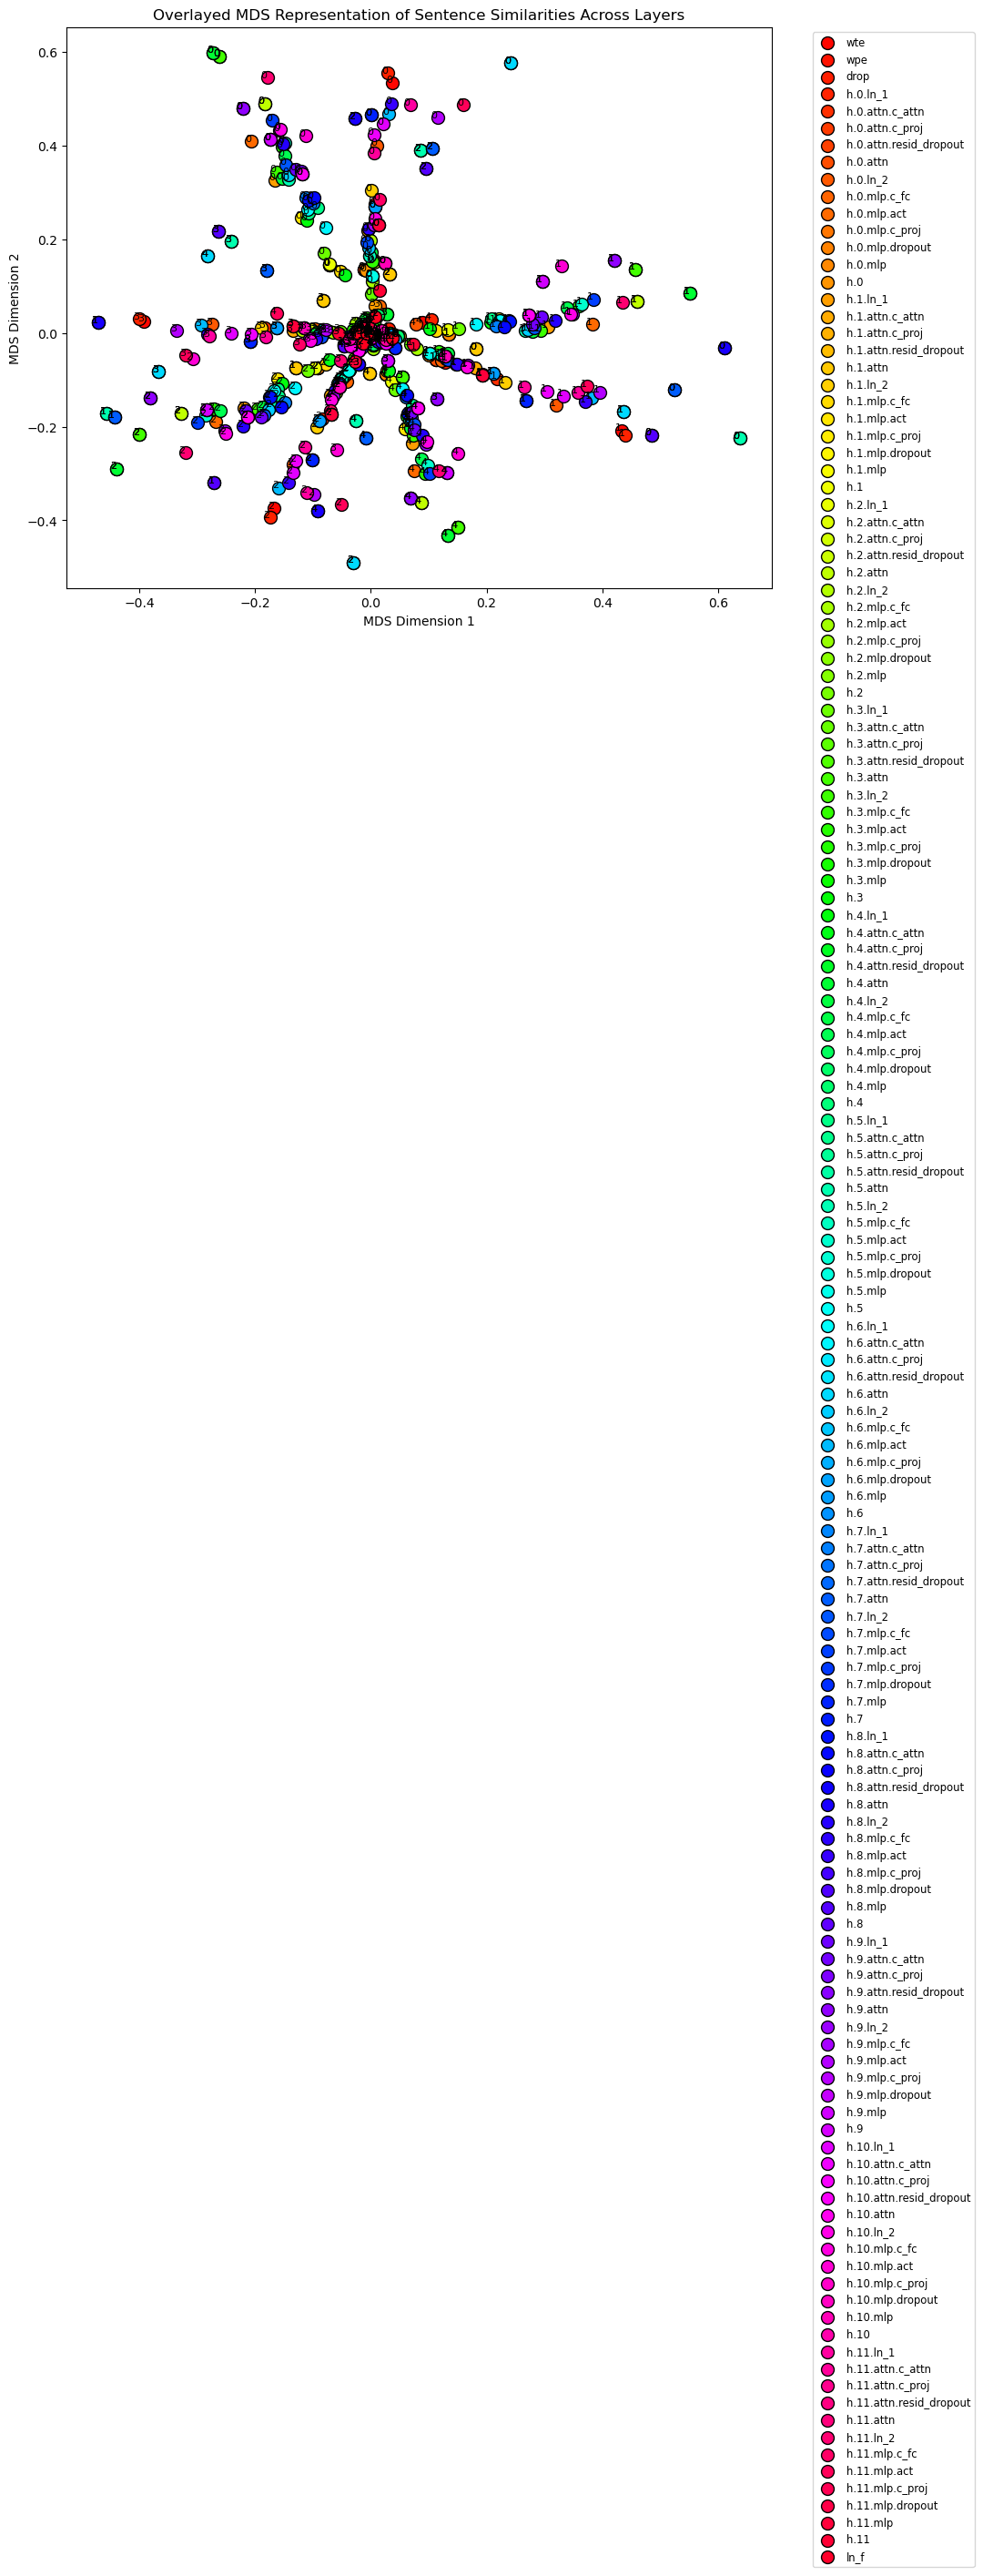

In [6]:
# Initialize the MDS model (same model for consistency across layers)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)

# Define a color palette for the layers
colors = sns.color_palette("hsv", len(activations))

# Plot all layers in a single figure
plt.figure(figsize=(10, 8))

for i, (layer, activation) in enumerate(activations.items()):
    # Compute the RDM and project to 2D with MDS
    rdm = compute_rdm(activation)
    points_2d = mds.fit_transform(rdm)
    
    # Plot the points with a distinct color for each layer
    plt.scatter(points_2d[:, 0], points_2d[:, 1], s=100, color=colors[i], label=layer, edgecolor="k")
    
    # Optionally, label each point by sentence index
    for j, (x, y) in enumerate(points_2d):
        plt.text(x, y, str(j), fontsize=8, ha="right")

# Customize plot
plt.title("Overlayed MDS Representation of Sentence Similarities Across Layers")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
plt.tight_layout()
plt.show()

In [ ]:
#### Rastaplot of between-Sentence RDM 

for layer, activation in activations.items():
    rdm = compute_rdm(activation)
    plt.figure(figsize=(8, 6))
    sns.heatmap(rdm, cmap="viridis", vmin=0, vmax=1)
    plt.title(f"RDM for Layer: {layer}")
    plt.show()
